## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

(referred to the following)
https://github.com/udacity/CarND-Camera-Calibration/blob/master/camera_calibration.ipynb

In [112]:
#import

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import copy
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline


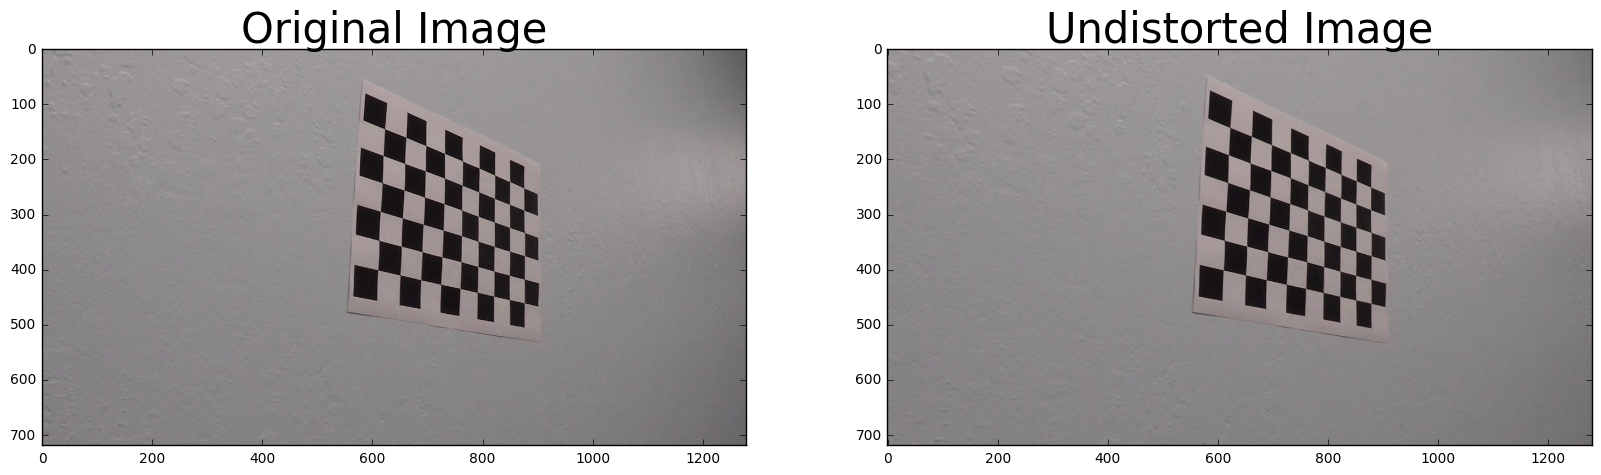

In [2]:
# chessboard size is 9x6
nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx * ny,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners and save image
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        # write image
        #write_name = './output_images/chessboard_corners/corners_found' + str(idx) + '.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img',img)
        cv2.waitKey(500)

# set image size
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# Step through the list and undistort image
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    # write image
    write_name = './output_images/chessboard_undist/undist' + str(idx) + '.jpg'
    cv2.imwrite(write_name, dst)
    cv2.imshow('undist_img', dst)
    cv2.waitKey(500)

# Save the camera calibration result for later use
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "./output_images/calibration_wide/wide_dist_pickle.p", "wb" ) )

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
        
cv2.destroyAllWindows()

## Next, apply a distortion correction to raw test images.

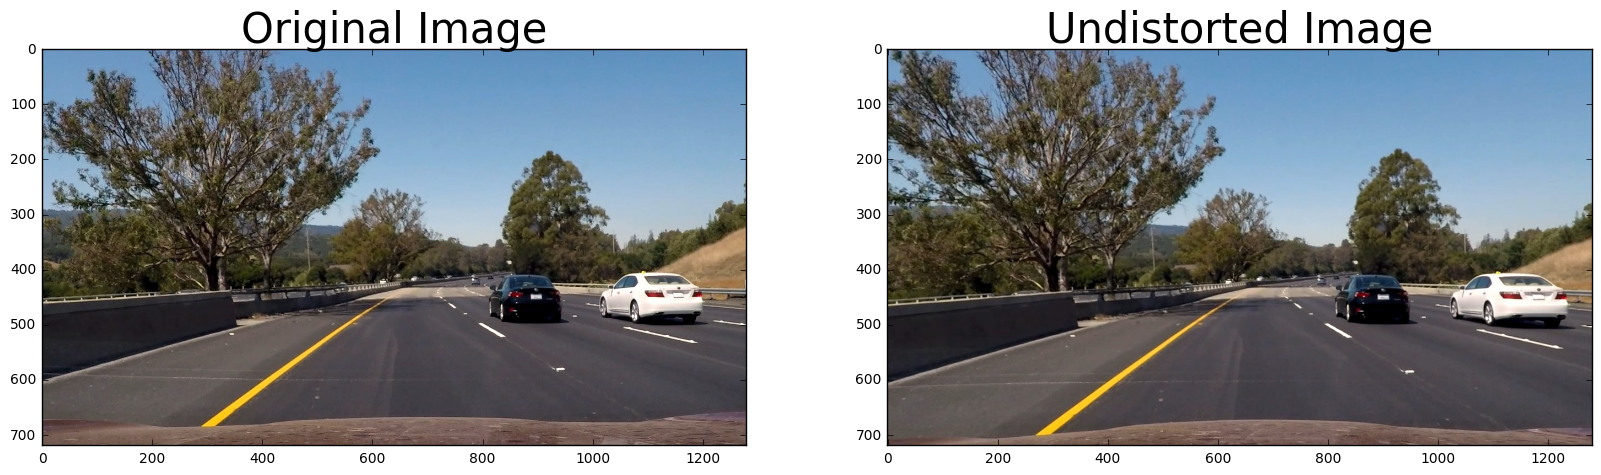

In [44]:
# Make a list of test images
images = glob.glob('./test_images/*.jpg')

# Read in the saved camera matrix and distortion coefficients
# These are the arrays calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "./output_images/calibration_wide/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Step through the list and apply a distortion correction and save image
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    # write image
    write_name = './output_images/test_images_undist/undist_' + fname.split('/')[-1]
    cv2.imwrite(write_name, dst)
    cv2.imshow('undist_img',dst)
    cv2.waitKey(500)

# Visualize undistortion

# for pyplot convert BGR to RGB
img_pyplot = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dst_pyplot = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img_pyplot)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst_pyplot)
ax2.set_title('Undistorted Image', fontsize=30)
        
cv2.destroyAllWindows()

## Use color transforms, gradients, etc., to create a thresholded binary image.

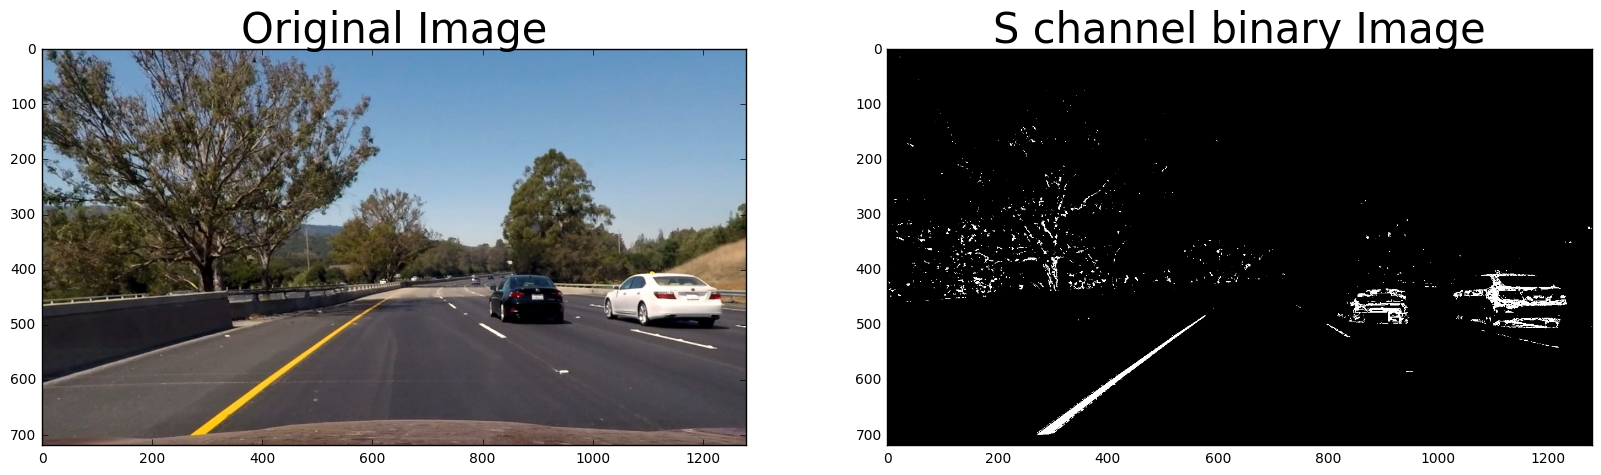

In [4]:
# Make a list of undistorted test images
images = glob.glob('./output_images/test_images_undist/*.jpg')

# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(0, 255)):
    # Convert to HLS color space
    img_hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    
    # Apply a threshold to the S channel
    binary_output = np.zeros_like(img_hls[:,:,2])
    binary_output[(img_hls[:,:,2] > thresh[0]) & (img_hls[:,:,2] <= thresh[1])] = 1
    
    # Return a binary image of threshold result
    return binary_output

# Define a function that thresholds absolute Sobel x or y 
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Calculate directional gradient
    if orient =='x':
        o_x,o_y= 1,0
    if orient == 'y':
        o_x,o_y= 0,1
    sobel = cv2.Sobel(gray,cv2.CV_64F,o_x,o_y)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Apply threshold
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel>thresh_min) & (scaled_sobel<thresh_max)] = 1
    return grad_binary

# Define a function that thresholds magnitude of the gradient
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Calculate gradient magnitude
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel_xy = np.sqrt(np.square(sobel_x) + np.square(sobel_y))
    scaled_sobel = np.uint8(255*abs_sobel_xy/np.max(abs_sobel_xy))
    
    # Apply threshold
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel>mag_thresh[0]) & (scaled_sobel<mag_thresh[1])] = 1
    return mag_binary

# Define a function that thresholds direction of the gradient
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Calculate gradient direction
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobelx = np.absolute(sobel_x)
    abs_sobely = np.absolute(sobel_y)
    grad_sobel = np.arctan2(abs_sobely, abs_sobelx)
    # Apply threshold
    dir_binary = np.zeros_like(grad_sobel)
    dir_binary[(grad_sobel > thresh[0]) & (grad_sobel < thresh[1])] = 1
    
    return dir_binary

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements


# Step through the list and apply binary thresholds and save image
for fname in images:
    image = cv2.imread(fname)
    # Apply each of the thresholding functions
    hls_binary = hls_select(image, thresh=(180, 255))
    
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.2))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined2 = np.zeros_like(combined)
    combined2[(gradx == 1)| (hls_binary == 1)] = 1
    
    # write image
    write_name = './output_images/binary/hls_' + fname.split('/')[-1]
    cv2.imwrite(write_name, hls_binary*255)
    write_name = './output_images/binary/combined_' + fname.split('/')[-1]
    cv2.imwrite(write_name, combined*255)
    write_name = './output_images/binary/combined2_' + fname.split('/')[-1]
    cv2.imwrite(write_name, combined2*255)
    
    cv2.imshow('hls_binary_img',hls_binary*255)
    cv2.waitKey(500)

    
# Visualize binary image
# for pyplot convert BGR to RGB
img_pyplot = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img_pyplot)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(hls_binary,'gray')
ax2.set_title('S channel binary Image', fontsize=30)
        
cv2.destroyAllWindows()


## Apply a perspective transform to rectify binary image ("birds-eye view").

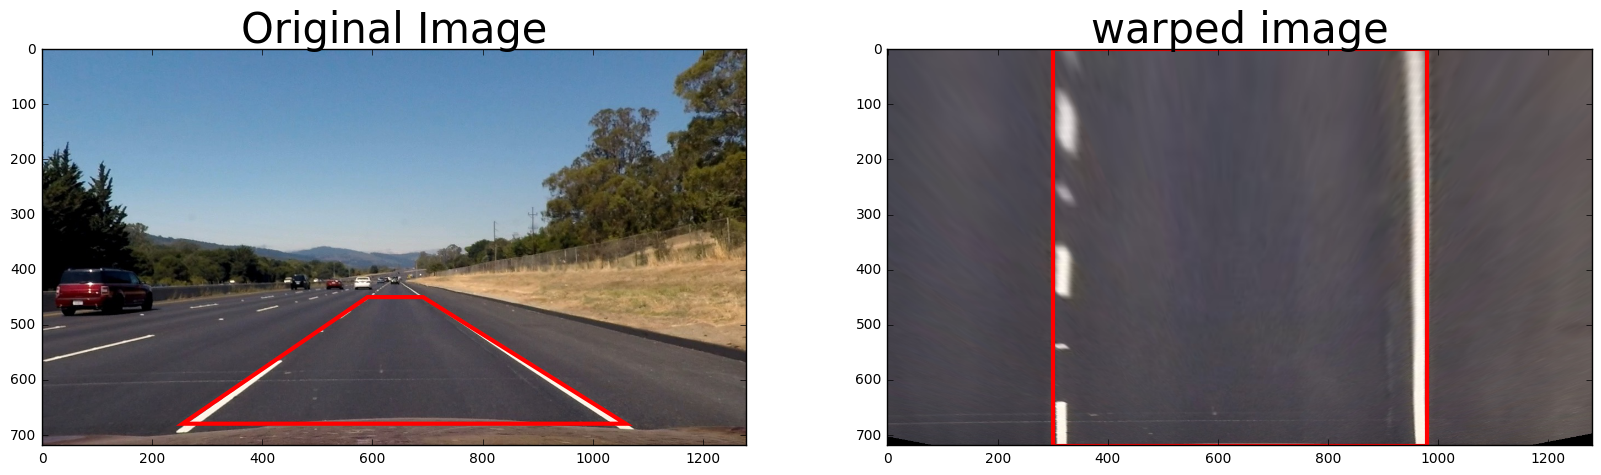

In [5]:
# Make a list of undistorted straight line images
images = glob.glob('./output_images/test_images_undist/undist_straight_lines*.jpg')

src = np.float32([[591,450], [255,680], [1060,680], [692,450]])
dst = np.float32([[300,0],[300,720],[980,720],[980,0]])
M = cv2.getPerspectiveTransform(src,dst)

# Step through the list and apply a distortion correction and save image
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    warped = cv2.warpPerspective(img, M, (1280,720))
    
    # write image
    write_name = './output_images/birds_eye/be_' + fname.split('/')[-1]
    cv2.imwrite(write_name, warped)
    cv2.imshow('warped_img',warped)
    cv2.waitKey(500)

# Visualize binary image
# for pyplot convert BGR to RGB
img_pyplot = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
warped_pyplot = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img_pyplot)
poly = plt.Polygon(src, fill = False, ec = 'red', linewidth = 3)
ax1.add_patch(poly)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped_pyplot)
poly = plt.Polygon(dst, fill = False, ec = 'red', linewidth = 3)
ax2.add_patch(poly)
ax2.set_title('warped image', fontsize=30)
        
cv2.destroyAllWindows()


## Detect lane pixels and fit to find the lane boundary.

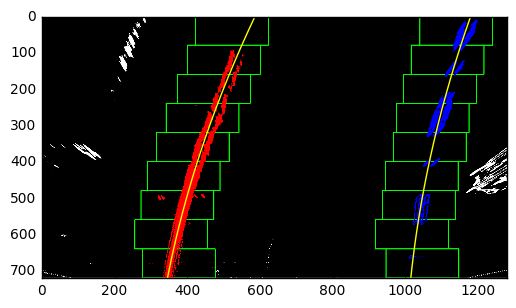

In [7]:
# Make a list of undistorted images
images = glob.glob('./output_images/test_images_undist/*.jpg')

# Step through the list and apply a distortion correction and save image
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    
    # transform birds-eye view
    warped = cv2.warpPerspective(img, M, (1280,720))
    
    # write image
    #write_name = './output_images/birds_eye/be_' + fname.split('/')[-1]
    #print(write_name)
    #cv2.imwrite(write_name, warped)
    cv2.imshow('warped_img',warped)
    cv2.waitKey(500)
    
    # Apply each of the thresholding functions
    hls_binary = hls_select(warped, thresh=(170, 255))
    
    gradx = abs_sobel_thresh(warped, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(warped, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(warped, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(warped, sobel_kernel=ksize, thresh=(0.7, 1.2))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined2 = np.zeros_like(combined)
    combined2[(gradx == 1)| (hls_binary == 1)] = 1
    
    cv2.imshow('combined_img',combined2)
    cv2.waitKey(500)
    
    # select binary image
    binary_warped = combined2
    
    # detect lane pixels
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    # Save fit line result for later use
    line_pickle = {}
    line_pickle["leftx"] = leftx
    line_pickle["lefty"] = lefty
    line_pickle["rightx"] = rightx
    line_pickle["righty"] = righty
    
    line_pickle["left_fit"] = left_fit
    line_pickle["right_fit"] = right_fit
    write_name = './output_images/fit_line/line_pickle' + str(idx) + '.p'
    pickle.dump( line_pickle, open( write_name, "wb" ) )
    
    # write image
    write_name = './output_images/lane_pixel/lp_' + fname.split('/')[-1]
    cv2.imwrite(write_name, out_img)
    cv2.imshow('out_img',out_img)
    cv2.waitKey(500)

plt.imshow(out_img*255)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

cv2.destroyAllWindows()


## Determine the curvature of the lane and vehicle position with respect to center.

In [8]:
# Make a list of detected lane images
images = glob.glob('./output_images/lane_pixel/*.jpg')


# Step through the list and apply a distortion correction and save image
for idx, fname in enumerate(images):

    # Read in the saved fit line result
    pickle_name = './output_images/fit_line/line_pickle' + str(idx) + '.p'
    line_pickle = pickle.load( open( pickle_name, "rb" ) )
    leftx = line_pickle["leftx"]
    lefty = line_pickle["lefty"]
    rightx = line_pickle["rightx"]
    righty = line_pickle["righty"]
    
    left_fit = line_pickle["left_fit"]
    right_fit = line_pickle["right_fit"]
    
    # Generate y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    # Define y-value where we want radius of curvature
    # choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    print(left_curverad, right_curverad)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3/80 # meters per pixel in y dimension
    xm_per_pix = 3.7/680 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print('radius of curvature = l:',left_curverad, 'm r: ', right_curverad, 'm')
    
    #calculate lane center
    left_x = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    right_x = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    lane_center = (left_x + right_x) / 2
    
    #calculate veicle position offset from lane center
    offset_lane = (lane_center - binary_warped.shape[1]/2) * xm_per_pix
    print('offset lane = ',offset_lane, 'm')
    


4943.63428363 6735.30552299
radius of curvature = l: 1268.36098605 m r:  1740.59154742 m
offset lane =  -0.0374321509096 m
20906.2222797 16162.9339707
radius of curvature = l: 5403.11746433 m r:  4176.15915273 m
offset lane =  0.00282527554901 m
1193.57908364 1254.5706007
radius of curvature = l: 307.123267579 m r:  320.27158323 m
offset lane =  0.214324435174 m
1288.70789202 910.723742267
radius of curvature = l: 332.849303353 m r:  230.781184198 m
offset lane =  0.224574107025 m
2493.86330313 1600.92813371
radius of curvature = l: 620.136532383 m r:  413.148557408 m
offset lane =  0.128818627143 m
2863.72101946 954.653276947
radius of curvature = l: 740.099126229 m r:  234.857805574 m
offset lane =  0.302511297879 m
947.665360813 823.927290152
radius of curvature = l: 240.586935885 m r:  196.148273505 m
offset lane =  0.0836730659386 m
2732.28089213 2947.56069498
radius of curvature = l: 668.509891916 m r:  749.749568707 m
offset lane =  0.220304780427 m


## Warp the detected lane boundaries back onto the original image.

radius of curvature = l: 1268.36098605 m r:  1740.59154742 m
radius of curvature = l: 5403.11746433 m r:  4176.15915273 m
radius of curvature = l: 307.123267579 m r:  320.27158323 m
radius of curvature = l: 332.849303353 m r:  230.781184198 m
radius of curvature = l: 620.136532383 m r:  413.148557408 m
radius of curvature = l: 740.099126229 m r:  234.857805574 m
radius of curvature = l: 240.586935885 m r:  196.148273505 m
radius of curvature = l: 668.509891916 m r:  749.749568707 m


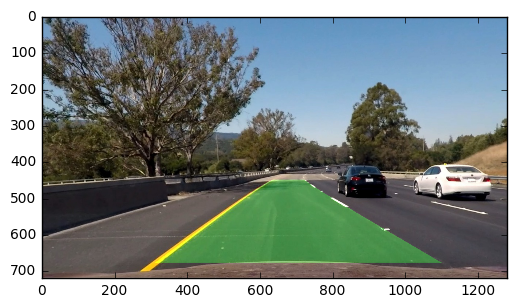

In [9]:
# Make a list of detected lane images
images = glob.glob('./output_images/test_images_undist/*.jpg')

# calculate inverse perspective matrix (Minv)
Minv = cv2.getPerspectiveTransform(dst,src)

# Step through the list and apply a distortion correction and save image
for idx, fname in enumerate(images):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = warp_zero
    
    # Read in the saved fit line result
    pickle_name = './output_images/fit_line/line_pickle' + str(idx) + '.p'
    line_pickle = pickle.load( open( pickle_name, "rb" ) )
    leftx = line_pickle["leftx"]
    lefty = line_pickle["lefty"]
    rightx = line_pickle["rightx"]
    righty = line_pickle["righty"]
    
    left_fit = line_pickle["left_fit"]
    right_fit = line_pickle["right_fit"]
    
    # Read images
    undist = cv2.imread(fname)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print('radius of curvature = l:',left_curverad, 'm r: ', right_curverad, 'm')
    # write image
    write_name = './output_images/boundary/b_' + fname.split('/')[-1]
    cv2.imwrite(write_name, result)
    cv2.imshow('result',result)
    cv2.waitKey(500)

result_pyplot = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
plt.imshow(result_pyplot)
plt.xlim(0, 1280)
plt.ylim(720, 0)

cv2.destroyAllWindows()


## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

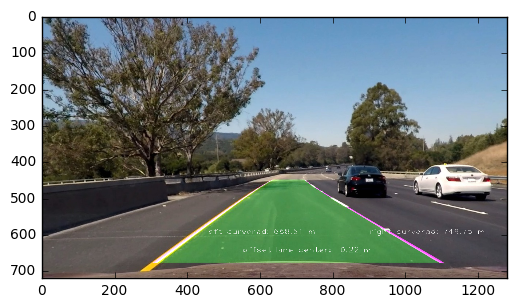

In [10]:
# Make a list of detected lane images
images = glob.glob('./output_images/boundary/*.jpg')

# Step through the list and draw lane boundaries and numerical estimation and save image
for idx, fname in enumerate(images):
    # Read images
    boundary = cv2.imread(fname)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = warp_zero
    
    # Read in the saved fit line result
    pickle_name = './output_images/fit_line/line_pickle' + str(idx) + '.p'
    line_pickle = pickle.load( open( pickle_name, "rb" ) )
    leftx = line_pickle["leftx"]
    lefty = line_pickle["lefty"]
    rightx = line_pickle["rightx"]
    righty = line_pickle["righty"]
    
    left_fit = line_pickle["left_fit"]
    right_fit = line_pickle["right_fit"]
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # set boundary pixel
    boundary_pixel = 10
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    
    pts_right = np.array([np.flipud(np.transpose(
        np.vstack([right_fitx, ploty])))])
    
    # Draw the lane boundary onto the warped blank image
    cv2.polylines(color_warp, np.int_([pts_left]), color = (255, 0, 255),
                  isClosed = False, thickness=boundary_pixel, lineType=cv2.LINE_AA)
    cv2.polylines(color_warp, np.int_([pts_right]), color = (255, 0, 255),
                  isClosed = False, thickness=boundary_pixel, lineType=cv2.LINE_AA)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    #calculate lane center
    left_x = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    right_x = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    lane_center = (left_x + right_x) / 2
    
    #calculate veicle position offset from lane center
    offset_lane = (lane_center - binary_warped.shape[1]/2) * xm_per_pix
    
    # set font
    font = cv2.FONT_HERSHEY_PLAIN
    # draw text
    text = 'left curverad: %5.2f m' % left_curverad
    cv2.putText(newwarp, text, (450,600),
                font, fontScale = 1.5, color = (255,255,255))
    text = 'right curverad: %5.2f m' % right_curverad
    cv2.putText(newwarp, text, (900,600),
                font, fontScale = 1.5, color = (255,255,255))
    text = 'offset lane center: %5.2f m' % offset_lane
    cv2.putText(newwarp, text, (550,650),
                font, fontScale = 1.5, color = (255,255,255))
    
    # Combine the result with the original image
    result = cv2.addWeighted(boundary, 1, newwarp, 1, 1)
    
    # write image
    write_name = './output_images/final_output/f_' + fname.split('/')[-1]
    cv2.imwrite(write_name, result)
    cv2.imshow('result',result)
    cv2.waitKey(500)
    
result_pyplot = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
plt.imshow(result_pyplot)
plt.xlim(0, 1280)
plt.ylim(720, 0)

cv2.destroyAllWindows()


## adopt pipeline to video images

In [149]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None 
        #y values for detected line pixels
        self.ally = None

# define class that buffers the line data
line_l0 = Line()
line_r0 = Line()
line_l1 = Line()
line_r1 = Line()
line_l2 = Line()
line_r2 = Line()
line_l3 = Line()
line_r3 = Line()
line_l4 = Line()
line_r4 = Line()

# Read in the saved camera matrix and distortion coefficients
# These are the arrays calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "./output_images/calibration_wide/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Define conversions in x and y from pixels space to meters
# (in my bird's eye view)
ym_per_pix = 3/80 # meters per pixel in y dimension
xm_per_pix = 3.7/680 # meters per pixel in x dimension

# Apply each of the thresholding functions
def binary_thresh(image, select_type = 'combined2'):
    # thresholding function input is BGR
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    hls_binary = hls_select(image, thresh=(80, 255))
    
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.2))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined2 = np.zeros_like(combined)
    combined2[(gradx == 1)| (hls_binary == 1)] = 1
    
    # select binary image
    if select_type == 'combined2':
        binary_thresh = combined2
    elif select_type == 'hls_binary':
        binary_thresh = hls_binary
    
    return binary_thresh
    
# Detect lane pixel first time
def lane_pixel_new(binary_warped, rl_select):
    # detect lane pixels
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    if rl_select == 'r':
        return rightx, righty
    if rl_select == 'l':
        return leftx, lefty

# Detect lane pixel after already detected
def lane_pixel(binary_warped, fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    lane_inds = ((nonzerox > (fit[0]*(nonzeroy**2) + fit[1]*nonzeroy + fit[2] - margin)) &
                 (nonzerox < (fit[0]*(nonzeroy**2) + fit[1]*nonzeroy + fit[2] + margin))) 
    
    # extract line pixel positions
    x = nonzerox[lane_inds]
    y = nonzeroy[lane_inds] 
    return x, y

# calculate fit line pixels
def fit_pixel(fit, ploty):
    # Generate x values for plotting
    fitx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    
    return fitx
    
# calculate radii of curvature and veicle position
def cal_curv_and_offset(leftx, lefty, rightx, righty, 
                        left_fit, right_fit, image_shape= (720, 1280)):
    # Generate y values for plotting
    ploty = np.linspace(0, image_shape[0]-1, image_shape[0] )
    
    # Define y-value where we want radius of curvature
    # choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    #calculate lane center
    left_x = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    right_x = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    lane_center = (left_x + right_x) / 2
    
    #calculate veicle position offset from lane center
    offset_lane = (lane_center - image_shape[1]/2) * xm_per_pix
    
    # calculate lane width
    lane_width = (right_x - left_x) * xm_per_pix
    
    return left_curverad, right_curverad, offset_lane, lane_width

# Check both lines ara roughly parallel
# Judged slope of fit curve shows close value
def chk_parallel(left_fit, right_fit):
    y = np.array([0, 720])
    dx_l = 2 * left_fit[0] * y + left_fit[1]
    dx_r = 2 * right_fit[0] * y + right_fit[1]
    return (abs(max(dx_l - dx_r)) < 0.15)
    
# draw lane and curverad and lane offset
def draw_lane_text(image, left_fit, right_fit, left_curverad,
                   right_curverad, offset_center):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(image).astype(np.uint8)
    color_warp = warp_zero
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    y_eval = np.max(ploty)
    
    # set boundary pixel
    boundary_pixel = 10
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(
        np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv,
                                  (image.shape[1], image.shape[0])) 
    
    # Draw the lane onto original image
    img_tmp = cv2.addWeighted(image, 1, newwarp, 0.3, 1)
    
    warp_zero = np.zeros_like(image).astype(np.uint8)
    color_warp2 = warp_zero
    # Draw the lane boundary onto the warped blank image
    cv2.polylines(color_warp2, np.int_([pts_left]), color = (255, 0, 255),
                  isClosed = False, thickness=boundary_pixel,
                  lineType=cv2.LINE_AA)
    cv2.polylines(color_warp2, np.int_([pts_right]), color = (255, 0, 255),
                  isClosed = False, thickness=boundary_pixel,
                  lineType=cv2.LINE_AA)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp2 = cv2.warpPerspective(color_warp2, Minv,
                                  (image.shape[1], image.shape[0])) 
    
    # set font
    font = cv2.FONT_HERSHEY_PLAIN
    # draw text
    text = 'left curverad: %5.2f m' % left_curverad
    cv2.putText(newwarp2, text, (450,600),
                font, fontScale = 1.5, color = (255,255,255))
    text = 'right curverad: %5.2f m' % right_curverad
    cv2.putText(newwarp2, text, (900,600),
                font, fontScale = 1.5, color = (255,255,255))
    text = 'offset lane center: %5.2f m' % offset_center
    cv2.putText(newwarp2, text, (550,650),
                font, fontScale = 1.5, color = (255,255,255))
    
    # Combine the result with the original image
    result = cv2.addWeighted(img_tmp, 1, newwarp2, 1, 0)
    
    return result

# Define a pipeline to process movies
def process_image(image):
    global line_l0, line_l1, line_l2, line_l3, line_l4
    global line_r0, line_r1, line_r2, line_r3, line_r4
    # buffer line class
    line_l4 = copy.deepcopy(line_l3)
    line_l3 = copy.deepcopy(line_l2)
    line_l2 = copy.deepcopy(line_l1)
    line_l1 = copy.deepcopy(line_l0)
    
    line_r4 = copy.deepcopy(line_r3)
    line_r3 = copy.deepcopy(line_r2)
    line_r2 = copy.deepcopy(line_r1)
    line_r1 = copy.deepcopy(line_r0)
    
    # adopt camera calibration
    dst = cv2.undistort(image, mtx, dist, None, mtx)
    
    # Apply a perspective transform
    warped = cv2.warpPerspective(dst, M, (1280,720))
    
    # create a thresholded binary image.
    binary_warped = binary_thresh(warped, 'combined2')
    
    # detect lane pixel
    if line_l0.detected == True:
        line_l0.allx, line_l0.ally = lane_pixel(binary_warped, 
                                               line_l0.current_fit)
    #elif line_l1.detected == True:
    #    line_l0.allx, line_l0.ally = lane_pixel(binary_warped, 
    #                                           line_l1.current_fit)
    else:
        line_l0.allx, line_l0.ally = lane_pixel_new(binary_warped, 'l')
    
    if line_r0.detected == True:
        line_r0.allx, line_r0.ally = lane_pixel(binary_warped, 
                                               line_r0.current_fit)
    #elif line_r1.detected == True:
    #    line_r0.allx, line_r0.ally = lane_pixel(binary_warped, 
    #                                           line_r1.current_fit)
    else:
        line_r0.allx, line_r0.ally = lane_pixel_new(binary_warped, 'r')

    # calculate current fit
    if len(line_l0.allx) != 0:
        line_l0.current_fit = np.polyfit(line_l0.ally, line_l0.allx, 2)
    if len(line_r0.allx) != 0:
        line_r0.current_fit = np.polyfit(line_r0.ally, line_r0.allx, 2)
    
    # calculate curverad and offset lane center
    line_l0.radius_of_curvature, line_r0.radius_of_curvature, line_l0.line_base_pos, lane_width = cal_curv_and_offset(
        line_l0.allx, line_l0.ally, line_r0.allx, line_r0.ally,
        line_l0.current_fit, line_r0.current_fit,
        binary_warped.shape)
    
    line_r0.line_base_pos = line_l0.line_base_pos
    
    # y values of the current fits of the line
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    
    # x values of the current fits of the line
    line_l0.recent_xfitted = fit_pixel(line_l0.current_fit,ploty)
    line_r0.recent_xfitted = fit_pixel(line_r0.current_fit,ploty)
    
    # Sanity check
    # Checking that they have similar curvature
    chk_curv = ((abs(line_l0.radius_of_curvature - line_r0.radius_of_curvature)/(line_l0.radius_of_curvature + line_r0.radius_of_curvature)) < 0.5)
    
    # Checking that they are separated by approximately the right distance horizontally
    chk_distance = (lane_width > 3) & (lane_width < 4)
    
    # Checking that they are roughly parallel
    chk_p = chk_parallel(line_l0.current_fit, line_r0.current_fit)
    
    # detect line 
    if chk_curv and chk_distance and chk_p:
        line_l0.detected = True
        line_r0.detected = True
    else:
        line_l0.detected = False
        line_r0.detected = False
    
    if line_l0.detected == False:
        # retry another binary image
        binary_warped = binary_thresh(warped, 'combined2')
        #detect lane pixel
        line_l0.allx, line_l0.ally = lane_pixel_new(binary_warped, 'l')
        if line_l0.allx == []:
            line_l0.allx = line_l0.recent_xfitted
            line_l0.ally = ploty
            print(line_l0.allx)
        # calculate current fit
        line_l0.current_fit = np.polyfit(line_l0.ally, line_l0.allx, 2)
        # x values of the current fits of the line
        line_l0.recent_xfitted = fit_pixel(line_l0.current_fit,ploty)
    
    if line_r0.detected == False:
        # retry another binary image
        binary_warped = binary_thresh(warped, 'combined2')
        #detect lane pixel
        line_r0.allx, line_r0.ally = lane_pixel_new(binary_warped, 'r')
        if line_r0.allx == []:
            return
        # calculate current fit
        line_r0.current_fit = np.polyfit(line_r0.ally, line_r0.allx, 2)
        # x values of the current fits of the line
        line_r0.recent_xfitted = fit_pixel(line_r0.current_fit,ploty)
    
    
    # calculate the last 4 average fit
    y_ave = None
    leftx_ave = None
    if line_l0.detected:
        leftx_ave = line_l0.recent_xfitted
        y_ave = ploty
    if line_l1.detected:
        leftx_ave = np.hstack([leftx_ave, line_l1.recent_xfitted])
        leftx_ave = [x for x in leftx_ave if x is not None]
        y_ave = np.hstack([y_ave, ploty])
        y_ave = [x for x in y_ave if x is not None]
    if line_l2.detected:
        leftx_ave = np.hstack([leftx_ave, line_l2.recent_xfitted])
        leftx_ave = [x for x in leftx_ave if x is not None]
        y_ave = np.hstack([y_ave, ploty])
        y_ave = [x for x in y_ave if x is not None]
    if line_l3.detected:
        leftx_ave = np.hstack([leftx_ave, line_l3.recent_xfitted])
        leftx_ave = [x for x in leftx_ave if x is not None]
        y_ave = np.hstack([y_ave, ploty])
        y_ave = [x for x in y_ave if x is not None]
    if line_l4.detected:
        leftx_ave = np.hstack([leftx_ave, line_l4.recent_xfitted])
        leftx_ave = [x for x in leftx_ave if x is not None]
        y_ave = np.hstack([y_ave, ploty])
        y_ave = [x for x in y_ave if x is not None]
    if (leftx_ave is None) or (y_ave is None):
        if line_l4.best_fit is not None:
            # Substitute with last best_fit 
            line_l0.best_fit = line_l4.best_fit
        else:
            line_l0.best_fit = line_l0.current_fit
    else:
        line_l0.best_fit = np.polyfit(y_ave, leftx_ave, 2)
        
    y_ave = None
    rightx_ave = None
    if line_r0.detected:
        rightx_ave = line_r0.recent_xfitted
        y_ave = ploty
    if line_r1.detected:
        rightx_ave = np.hstack([rightx_ave, line_r1.recent_xfitted])
        rightx_ave = [x for x in rightx_ave if x is not None]
        y_ave = np.hstack([y_ave, ploty])
        y_ave = [x for x in y_ave if x is not None]
    if line_r2.detected:
        rightx_ave = np.hstack([rightx_ave, line_r2.recent_xfitted])
        rightx_ave = [x for x in rightx_ave if x is not None]
        y_ave = np.hstack([y_ave, ploty])
        y_ave = [x for x in y_ave if x is not None]
    if line_r3.detected:
        rightx_ave = np.hstack([rightx_ave, line_r3.recent_xfitted])
        rightx_ave = [x for x in rightx_ave if x is not None]
        y_ave = np.hstack([y_ave, ploty])
        y_ave = [x for x in y_ave if x is not None]
    if line_r4.detected:
        rightx_ave = np.hstack([rightx_ave, line_r4.recent_xfitted])
        rightx_ave = [x for x in rightx_ave if x is not None]
        y_ave = np.hstack([y_ave, ploty])
        y_ave = [x for x in y_ave if x is not None]
    if (rightx_ave is None) or (y_ave is None):
        if line_r4.best_fit is not None:
            # Substitute with last best_fit 
            line_r0.best_fit = line_r4.best_fit
        else:
            line_r0.best_fit = line_r0.current_fit
    else:
        line_r0.best_fit = np.polyfit(y_ave, rightx_ave, 2)
    
    # draw lane and text
    result = draw_lane_text(dst, line_l0.best_fit,
                            line_r0.best_fit, line_l0.radius_of_curvature,
                            line_r0.radius_of_curvature, line_l0.line_base_pos)
    
    return result

# process movie
project_output = './output_images/project_challenge2.mp4'
clip = VideoFileClip('harder_challenge_video.mp4')
project_clip = clip.fl_image(process_image)
%time project_clip.write_videofile(project_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))   


[MoviePy] >>>> Building video ./output_images/project_challenge2.mp4
[MoviePy] Writing video ./output_images/project_challenge2.mp4


  0%|          | 0/1200 [00:00<?, ?it/s]WARNING:py.warnings://anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:353: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


100%|█████████▉| 1199/1200 [40:22<00:00,  1.61it/s]    


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/project_challenge2.mp4 

CPU times: user 12min 7s, sys: 4min 31s, total: 16min 38s
Wall time: 40min 24s


In [81]:
import copy

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

a
a = Line()
b
b = Line()
a.ally = 1
a.allx = 2

def process():
    global a,b
    b = copy.deepcopy(a)
    a.ally += 1
    return
    
for i in range(0,5):
    process()
    print(a.ally, b.ally)
    
rightx_ave = None
add =[1,2,3]
rightx_ave = np.hstack([rightx_ave, add])
rightx_ave = np.nonzero(rightx_ave)
print(rightx_ave)

2 1
3 2
4 3
5 4
6 5
(array([1, 2, 3]),)


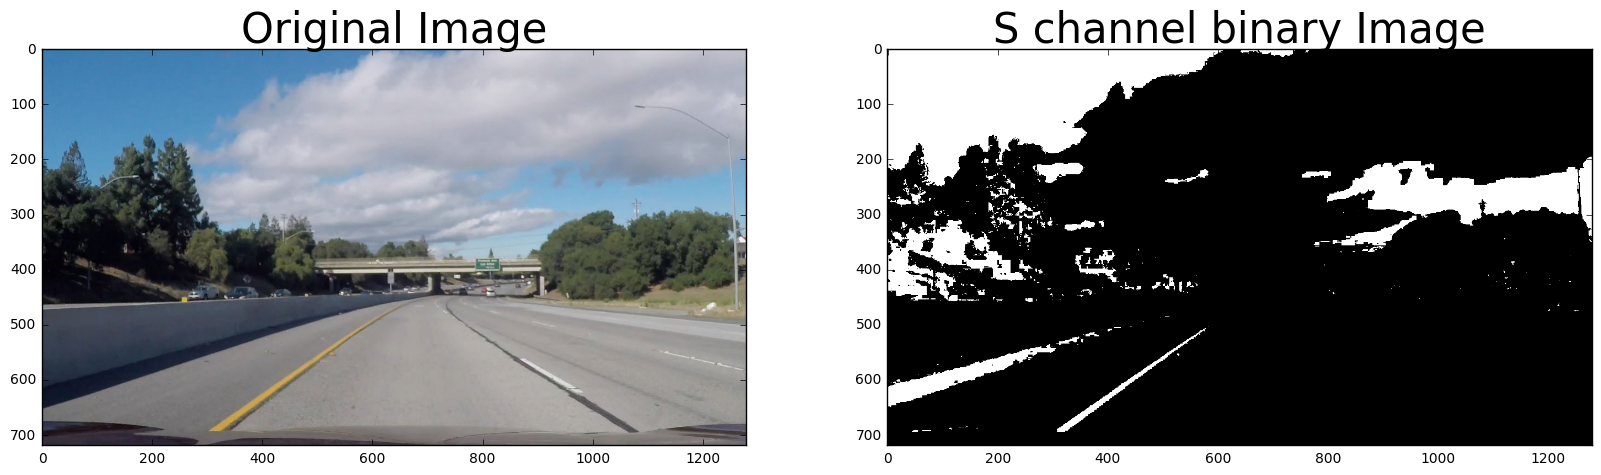

In [142]:

image = cv2.imread('error_challenge.jpg')

# Apply each of the thresholding functions
hls_binary = hls_select(image, thresh=(80, 255))

gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.2))
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
combined2 = np.zeros_like(combined)
combined2[(gradx == 1)| (hls_binary == 1)] = 1
    
# Visualize binary image
# for pyplot convert BGR to RGB
img_pyplot = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img_pyplot)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(hls_binary,'gray')
ax2.set_title('S channel binary Image', fontsize=30)
        
cv2.destroyAllWindows()


In [117]:
# process movie
project_output = './output_images/project_challenge.mp4'
clip = VideoFileClip('challenge_video.mp4')
project_clip = clip.fl_image(process_image)
%time project_clip.write_videofile(project_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))   


TypeError: expected non-empty vector for x